# Script Análisis Matrices AJP y Linealización

A continuación se definen las direrentes funciones requeridas para realizar una evaluación multicriterio difusa o clásica, contando con:

- Matrices de juicio por pares.
- Evaluación de consistencia.
- Cálculo de pesos propios.
- Ajustes por linealización.

### Estructura general del script

Cada bloque del script sigue este patrón:

1.	MatrizInicial.- Contiene datos brutos de entrada.
2.	Anális AJP.- Tiene estructuras con fracciones tipo 1/3, 1/5, etc. → forma clásica del método de comparación por pares (AHP/AJP).
3.	Linealización=0 y Linealización~0.1.- Aquí se calcula una forma ajustada de la matriz original, con técnicas como:
    -	Logaritmo de cada entrada.
    -	Proyección a matrices consistentes.
    -	Cálculo del peso relativo ajustado.


In [1]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Funciones para análisis de matrices de juicio por pares

# Calcula ln(matrix) para toda la matriz de comparación.
def log_transform(matrix):
    matrix = np.array(matrix, dtype=float)
    return np.log(matrix)

# Suma filas/columnas para proyectar a un vector de preferencia.
def project_to_vector(matrix_log):
    return np.sum(matrix_log, axis=1)

# Usa un vector base para reconstruir una matriz consistente.
def consistent_matrix_from_vector(vector):
    n = len(vector)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mat[i, j] = vector[i] / vector[j]
    return mat

# Calcula pesos relativos (vía media geométrica o normalización de log-proyecciones).
def priority_vector(matrix):
    matrix = np.array(matrix, dtype=float)
    product = np.prod(matrix, axis=1)
    weights = product ** (1 / matrix.shape[0])
    return weights / np.sum(weights)

def print_matrix(mat, title='', nombre='', datos_contacto='', area_experiencia='', procedencia=''):
    df = pd.DataFrame(mat)
    if title != '': print(f"Matríz: {title}")
    if nombre != '': print(f"Nombre: {nombre}")
    if datos_contacto != '': print(f"Datos de contacto: {datos_contacto}")
    if area_experiencia != '': print(f"Área de experiencia: {area_experiencia}")
    if procedencia != '': print(f"Procedencia: {procedencia}", "\n")
    display(df)
    

Componentes del anális AJP:

1.	Matriz de juicio por pares
	•	Declarada previamente como A.
2.	Vector propio o de prioridad
	•	Calculado con priority_vector(A).
3.	Cálculo de la razón de consistencia (CR), para lo que se requiere:
	•	λ_max: valor propio principal.
	•	Índice de consistencia (CI):
    CI = \frac{\lambda_{\text{max}} - n}{n - 1}
	•	Razón de consistencia (CR):
    CR = \frac{CI}{RI_n}

Donde RI_n es un valor esperado de inconsistencia para matrices aleatorias de orden n.

In [3]:
# Función para analizar consistencia AJP

# Índice de consistencia aleatoria (RI) para matrices de tamaño 1 a 10.
RI_dict = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
}

def ajp_consistency_ratio(matrix):
    n = matrix.shape[0]
    weights = priority_vector(matrix)
    Aw = np.dot(matrix, weights)
    lambda_max = np.sum(Aw / weights) / n
    CI = (lambda_max - n) / (n - 1)
    RI = RI_dict.get(n, 1.49)
    CR = CI / RI if RI != 0 else 0
    print(f'λ_max = {lambda_max:.4f}')
    print(f'CI = {CI:.4f}')
    print(f'CR = {CR:.4f}')

In [4]:
# --- Matriz Inicial ---

# Se setean los diferentes criterios de la matriz inicial
nombre = "N/A"
datos_contacto = "N/A"
area_experiencia = "Bombeo"
procedencia = "Michoacán"

A = np.array([
    [1.0, 0.2, 3.0, 5.0],
    [5.0, 1.0, 0.2, 3.0],
    [0.333333, 5.0, 1.0, 3.0],
    [0.2, 0.333333, 0.333333, 1.0]
])

print_matrix(A, 'Matriz Inicial', nombre, datos_contacto, area_experiencia, procedencia)

Matríz: Matriz Inicial
Nombre: N/A
Datos de contacto: N/A
Área de experiencia: Bombeo
Procedencia: Michoacán 



,0,1,2,3
0,1.000000,0.200000,3.000000,5.0
1,5.000000,1.000000,0.200000,3.0
2,0.333333,5.000000,1.000000,3.0
3,0.200000,0.333333,0.333333,1.0


In [5]:
# --- Análisis de consistencia AJP ---
ajp_consistency_ratio(A)

λ_max = 5.9401
CI = 0.6467
CR = 0.7185


In [6]:
# --- Análisis: Linealización = 0 ---
L_A = log_transform(A)
print_matrix(L_A, 'L(A) - Logaritmo natural')

proj = project_to_vector(L_A)
print('Proyección (suma filas):', proj)

reconstruida = consistent_matrix_from_vector(np.exp(proj))
print_matrix(reconstruida, 'Matriz consistente reconstruida')

Matríz: L(A) - Logaritmo natural


,0,1,2,3
0,0.000000,-1.609438,1.098612,1.609438
1,1.609438,0.000000,-1.609438,1.098612
2,-1.098613,1.609438,0.000000,1.098612
3,-1.609438,-1.098613,-1.098613,0.000000


Proyección (suma filas): [ 1.09861229  1.09861229  1.60943691 -3.80666449]
Matríz: Matriz consistente reconstruida


,0,1,2,3
0,1.000000,1.000000,0.600001,135.000270
1,1.000000,1.000000,0.600001,135.000270
2,1.666665,1.666665,1.000000,225.000225
3,0.007407,0.007407,0.004444,1.000000


In [7]:
# --- Análisis: Linealización ~0.1 ---
vp = priority_vector(A)
print('Vector de prioridad (normalizado):', vp)

Vector de prioridad (normalizado): [0.29158008 0.29158008 0.33129886 0.08554098]


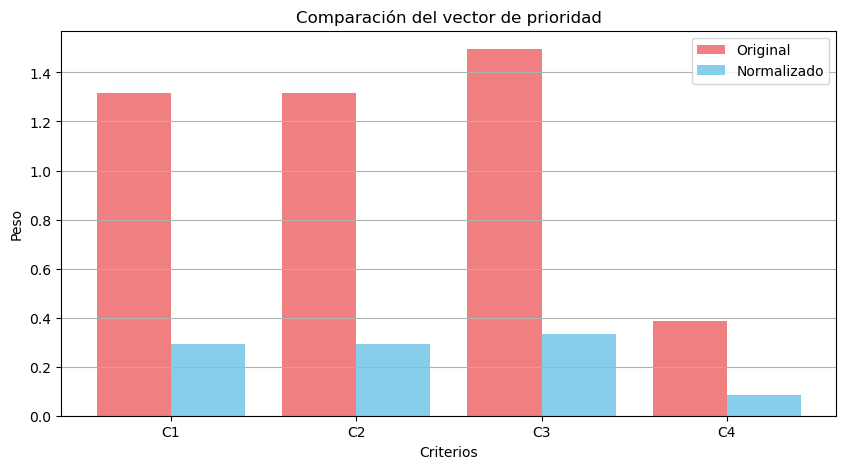

In [8]:
# Comparación del vector de prioridad original vs normalizado como gráfico de barras
product = np.prod(A, axis=1)
vp_original = product ** (1 / A.shape[0])
vp_normalizado = vp_original / np.sum(vp_original)
criterios = [f'C{i+1}' for i in range(len(vp_original))]
x = np.arange(len(criterios))
plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, vp_original, width=0.4, label='Original', color='lightcoral')
plt.bar(x + 0.2, vp_normalizado, width=0.4, label='Normalizado', color='skyblue')
plt.xticks(x, criterios)
plt.xlabel('Criterios')
plt.ylabel('Peso')
plt.title('Comparación del vector de prioridad')
plt.legend()
plt.grid(axis='y')
plt.show()